In [ ]:
!pip install clearml

In [ ]:
import itertools

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from clearml import Task
from tqdm import tqdm

In [ ]:
%env CLEARML_WEB_HOST= ...
%env CLEARML_API_HOST= ...
%env CLEARML_FILES_HOST= ...

%env CLEARML_API_ACCESS_KEY= ...
%env CLEARML_API_SECRET_KEY= ...

### Data

In [ ]:
from google.colab import drive


drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!mv /content/drive/MyDrive/cats_dataset.zip .

In [ ]:
!unzip cats_dataset.zip

In [ ]:
def denormalize(x):
    y = x * torch.tensor([0.5]).type_as(x)
    z = y + torch.tensor([0.5]).type_as(y)
    return z

In [ ]:
transform = T.Compose(
    [
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
)

dataset = torchvision.datasets.ImageFolder(root="cats_dataset", transform=transform)

In [ ]:
class LoadedImagesDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = []
        for d in dataset:
            self.data.append(d)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [ ]:
loaded_dataset = LoadedImagesDataset(dataset)

len(loaded_dataset)

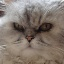

In [ ]:
TF.to_pil_image(denormalize(loaded_dataset[0][0]))

### Setting up an experiment

In [ ]:
from src.models.vanilla_gan import Discriminator, Generator

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
BATCH_SIZE = 1024
N_EPOCHS = 1
SAMPLE_INTERVAL = 10
N_IMAGES = 5

IMG_SIZE = 64
LATENT_DIM = 128
N_CHANNELS = 1024

D_iters = 3
G_iters = 2

lr = 2e-4
b1 = 0.5
b2 = 0.9999

parameters = {
    "batch size": BATCH_SIZE,
    "number of epochs": N_EPOCHS,
    "sample interval": SAMPLE_INTERVAL,
    "number of images in sample": N_IMAGES,
    "image size": IMG_SIZE,
    "latent dim": LATENT_DIM,
    "number of channels": N_CHANNELS,
    "d iters": D_iters,
    "g iters": G_iters,
    "b1 b2": (b1, b2),
    "lr": lr,
}

task_name = "experiment_1.3"

In [ ]:
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
netG = Generator(img_size=IMG_SIZE, latent_dim=LATENT_DIM, n_channels=N_CHANNELS).to(
    device
)
netD = Discriminator(img_size=IMG_SIZE, n_channels=N_CHANNELS).to(device)
netG = netG.apply(weights_init)
netD = netD.apply(weights_init)

In [ ]:
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(b1, b2))
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(b1, b2))

loss_fn = nn.BCELoss()

In [ ]:
def discriminator_train_iteration(
    netD: nn.Module, netG: nn.Module, optimizerD: torch.optim.optimizer, data_iter
) -> tuple[torch.Tensor, torch.Tensor]:
    real_batch, _ = next(data_iter)
    real_batch = real_batch.to(device)
    bs = real_batch.shape[0]

    optimizerD.zero_grad()

    y_real = torch.ones(bs, 1).to(device)
    outD_real = netD(real_batch)
    errD_real = loss_fn(outD_real, y_real)
    errD_real.backward()

    noise_batch = torch.randn(bs, LATENT_DIM).to(device)
    fake_batch = netG(noise_batch).detach()
    y_fake = torch.zeros(bs, 1).to(device)
    outD_fake = netD(fake_batch)
    errD_fake = loss_fn(outD_fake, y_fake)
    errD_fake.backward()

    return errD_real, errD_fake


def generator_train_iteration(
    netG: nn.Module, optimizerD: torch.optim.optimizer, data_iter
) -> torch.Tensor:
    optimizerG.zero_grad()

    noise_batch = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)

    fake_batch = netG(noise_batch)

    outD_gen = netD(fake_batch)
    y_gen = torch.ones(BATCH_SIZE, 1).to(device)
    errG = loss_fn(outD_gen, y_gen)
    errG.backward()

    optimizerG.step()

    return errG

In [ ]:
task = Task.init(project_name="Cats generation", task_name=task_name)
task.connect(parameters)
logger = task.get_logger()

data_iter = itertools.cycle(iter(dataloader))

netG.train()
netD.train()

sample_noise = torch.randn(N_IMAGES, LATENT_DIM).to(device)

for epoch in tqdm(range(N_EPOCHS), total=N_EPOCHS):
    for i in range(len(dataloader)):
        steps_done = epoch * len(dataloader) + i

        j = 0
        while j < D_iters:
            j += 1

            errD_real, errD_fake = discriminator_train_iteration(
                netD, netG, optimizerD, data_iter
            )
            errD = (errD_real + errD_fake) / 2

            logger.report_scalar(
                title="discriminator/real_loss",
                series="series A",
                iteration=steps_done,
                value=errD_real.detach().cpu().item(),
            )
            logger.report_scalar(
                title="discriminator/fake_loss",
                series="series A",
                iteration=steps_done,
                value=errD_fake.detach().cpu().item(),
            )
            logger.report_scalar(
                title="discriminator/loss",
                series="series A",
                iteration=steps_done,
                value=errD.detach().cpu().item(),
            )

            optimizerD.step()

        j = 0
        while j < G_iters:
            j += 1

            errG = generator_train_iteration(netG, optimizerG, data_iter)

            logger.report_scalar(
                title="generator/real_loss",
                series="series A",
                iteration=steps_done,
                value=errG.detach().cpu().item(),
            )

        if steps_done % SAMPLE_INTERVAL == 0:
            with torch.no_grad():
                netG.eval()

                images = netG(sample_noise)

                for i, img in enumerate(images):
                    image = TF.to_pil_image(denormalize(img))
                    logger.report_image(
                        f"Image {i}", "image PIL", iteration=steps_done, image=image
                    )

                netG.train()

task.close()

In [ ]:
torch.save(
    {
        "netG": netG.state_dict(),
        "netD": netD.state_dict(),
        "optG": optimizerG.state_dict(),
        "optD": optimizerD.state_dict(),
    },
    task_name + ".pth",
)